# 4. Model
# 4.1 ARIMA:  
Use differencing to convert a non-stationary time series into a stationary one, and then predict future values from historical data.

**Key Requirement/Assumption:**
- Linearity
- Stationary
- Independence of Errors: no autocorrelation in the residuals
- No Seasonal Patterns --> otherwise, apply seasonal ARIMA

**AR**: Assume analytical componnets based on the assuption that future value of the series can be predicted using its own past values (its own lag terms). To figure out the order of an AR model, you would use the PACF.

**MA**: Assume current value is dependent on the error terms including the current error. To figure out the order of an MA model, you would use the ACF.

**I**: Evaluate differences in time series

**ARIMA(p,d,q) order specification:**
- stationary/nonstationary --> d
- ACF(autocorrelation function) --> q/MA
- PACF(partial autocorrelation function) --> P/AR

**Evaluation Criteria:**
- AIC(Akaike information criterion, AIC)
- PIC(Baysian information criterion, BIC)


**weekness:**
The need for manual selection of hyperparameters as the state of systems can gradually change over time.

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
#os.chdir('/content/drive/MyDrive')
#!ls

import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import time

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.simplefilter("ignore")

In [ ]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [ ]:
# read dataset
df = pd.read_csv('/content/drive/MyDrive/FinalData/dataset.csv')
df.set_index('Date', inplace=True)
df.head()

,AAPL,AMZN,GOOG,MSFT
Date,,,,
2000-01-03,0.848323,4.468750,138.729996,36.205601
2000-01-04,0.776801,4.096875,138.729996,34.982586
2000-01-05,0.788168,3.487500,138.729996,35.351429
2000-01-06,0.719961,3.278125,138.729996,34.167225
2000-01-07,0.754065,3.478125,138.729996,34.613708


# 4.1.1 Specify the order of the Model

## Step 1: Check stationary
--> use Dickey-Fuller test to check stationary

**Null Hypothesis**: The series has a unit root/the data series is not stationary

**Alternate Hypothesis**: The series has no unit root/the data series stationary



In [ ]:
def Test_Stationarity(company):
  result = adfuller(df[company], autolag = 'AIC')
  print("Results of Dickey Fuller Test for " + company )
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#result = adfuller(stock_price_df["AAPL"],autolag = 'AIC')
for col in df.columns:
  print(col)
  print(Test_Stationarity(col))
  print('----------------------')

AAPL
Results of Dickey Fuller Test for AAPL
Test Statistics: 1.855147097241853
p-value: 0.9984523431001769
Number of lags used: 30
Number of observations used: 5948
critical value (1%): -3.431449886410609
critical value (5%): -2.8620260479098296
critical value (10%): -2.5670287209582354
None
----------------------
AMZN
Results of Dickey Fuller Test for AMZN
Test Statistics: -0.1098346330993528
p-value: 0.948450112876673
Number of lags used: 34
Number of observations used: 5944
critical value (1%): -3.431450626896445
critical value (5%): -2.862026375075407
critical value (10%): -2.5670288951173266
None
----------------------
GOOG
Results of Dickey Fuller Test for GOOG
Test Statistics: -1.4934364865355059
p-value: 0.5367556804249336
Number of lags used: 0
Number of observations used: 5978
critical value (1%): -3.4314443643668904
critical value (5%): -2.8620236081271426
critical value (10%): -2.567027422196319
None
----------------------
MSFT
Results of Dickey Fuller Test for MSFT
Test St

**Result:**

The p-value > 0.05, so we cannot reject the Null hypothesis that the data series is not stationary. Hence, I would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.



## Step 2: Determine p and q
Based on ACF and PACF, we can determine q and p respectively.

**ACF plot answers:**
1. Is the observed time series white noise / random?
2. Is an observation related to an adjacent observation, an observation twice-removed, and so on?
3. Can the observed time series be modeled with an MA model? If yes, what is the order?

**PACF(indirect correlation are removed) plot answers:**
1. Can the observed time series be modeled with an AR model? If yes, what is the order?

In the ACF and PACF plot, you will see a blue area, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.


**Result:**

ACF Plot: The Auto Correlation Function (ACF) values decrease along with the lags, not decay quickly, and show significant correlation across lags(the autocorrelation for previous time remains almost the same). This shows that stock prices are highly correlated with each other. In other words, when the price of the stock rises, it tends to continue rising. When the price of the stock falls, it tends to continue falling.

For GOOG: (p, d, q) = (3, d, High Autocorrelation)

For AMZN: (p, d, q) = (3, d, High Autocorrelation)

For MSFT: (p, d, q) = (3, d, High Autocorrelation)

For AAPL: (p, d, q) = (3, d, High Autocorrelation)

AAPL


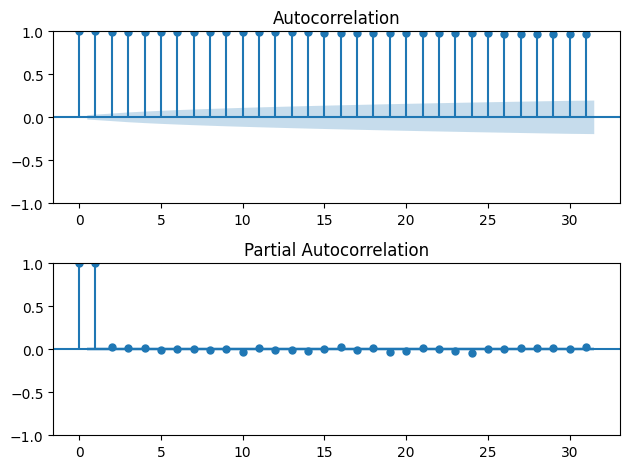

AMZN


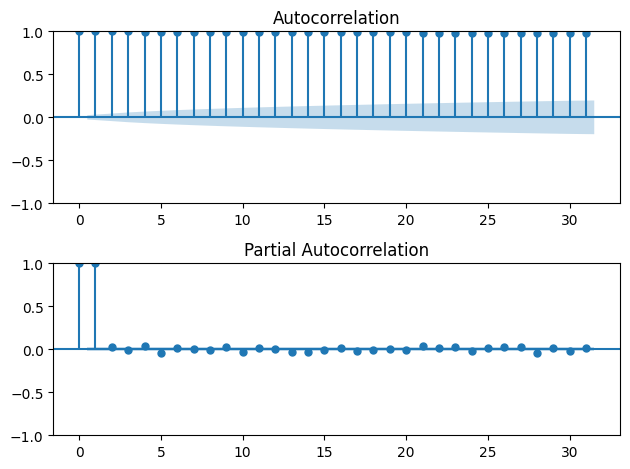

GOOG


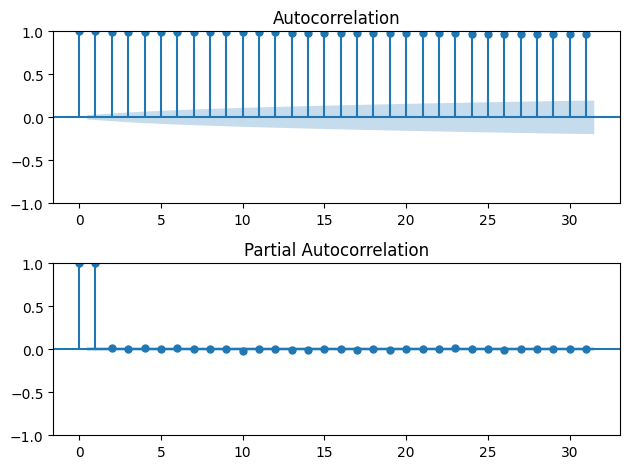

MSFT


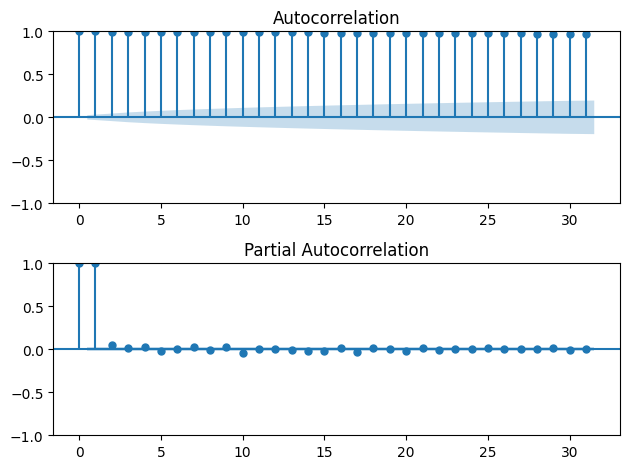

In [ ]:
def draw_acf_pacf(timeSeries, lags=31):
    '''acf pacf 默认为31阶差分 '''
    # bestdiff = best_diff(timeSeries)
    # 差分运算
    # ts_diff = timeSeries.diff(int(bestdiff))
    # ts_diff.dropna(inplace=True)

    # 绘图
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(timeSeries, lags=lags, ax=ax1)

    ax2 = f.add_subplot(212)
    plot_pacf(timeSeries, lags=lags, ax=ax2)
    f.tight_layout(h_pad=1)
    plt.show()
    plt.close()

for col in df.columns:
  print(col)
  draw_acf_pacf(df[col])

**Transformation to make the data more statioanry before apply ARIMA:**

**Even though the daily prices of Apple stock are highly correlated,indicating non-stationnary and trend, the daily returns may not be. we can compute the daily returns from the daily prices as follows:**

Assume NO Divident paid

r_t = ln(P_t / P_t-1 )

**The ln function is to reduce the magnitude of the values and reduce the series rising trend.**


AAPL


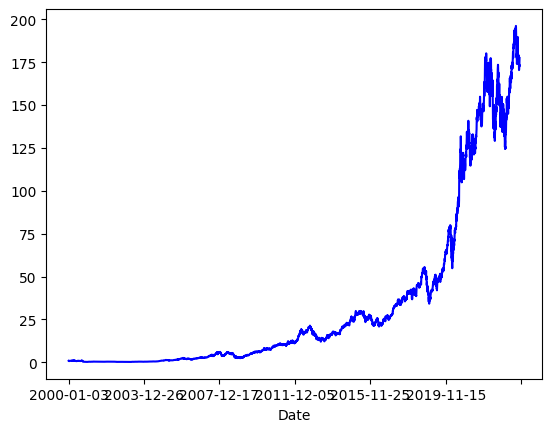

AMZN


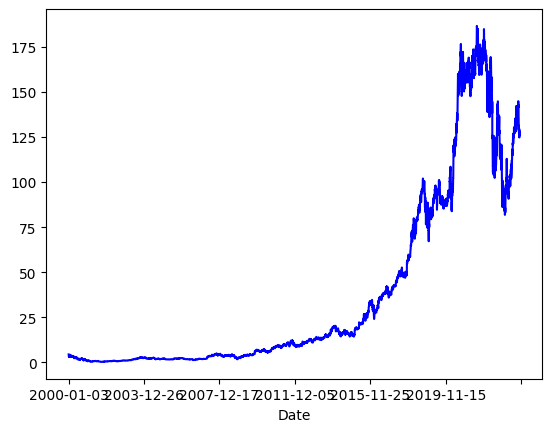

GOOG


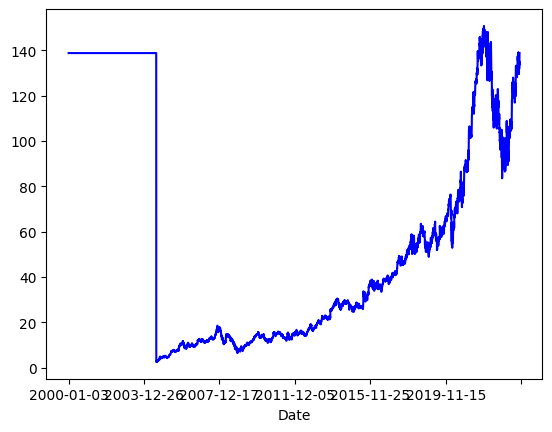

MSFT


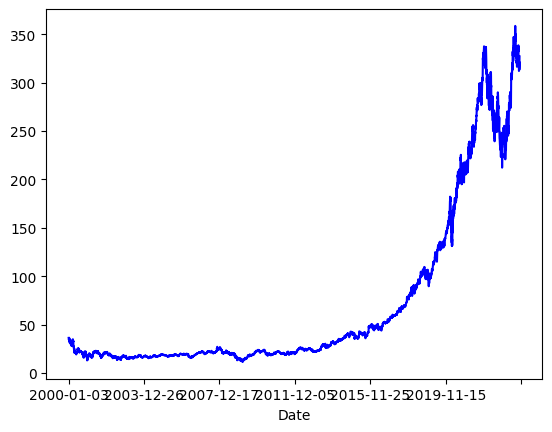

In [ ]:
# plot the Adj close price before transformation for comaprison
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue',label = "original Series")
    plt.show()

for col in df.columns:
  print(col)
  draw_ts(df[col])

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

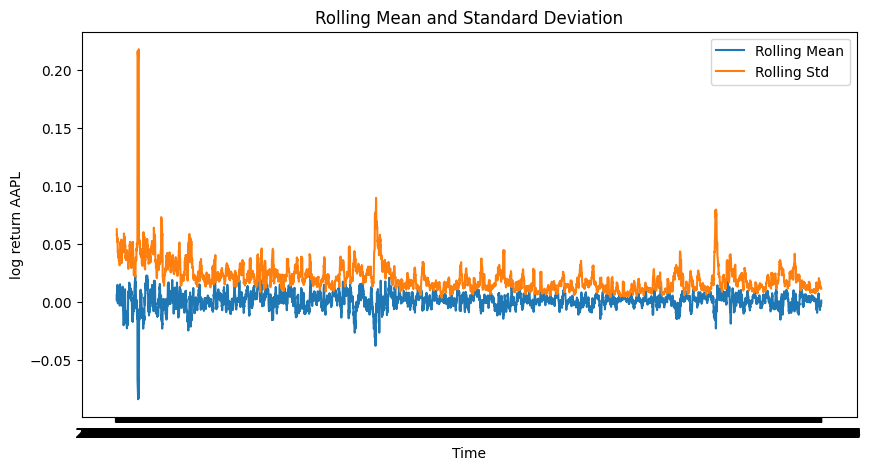

In [ ]:
df["AAPL_t-1"] = df["AAPL"].shift(1)
df['log return AAPL'] = np.log(df["AAPL"]/ df["AAPL_t-1"])

AAPL_log_moving_avg = df['log return AAPL'].rolling(12).mean()
AAPL_log_std = df['log return AAPL'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(df.index, AAPL_log_moving_avg, label = "Rolling Mean")
plt.plot(df.index, AAPL_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log return AAPL')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

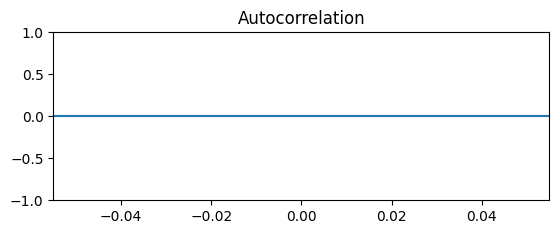

In [ ]:
f = plt.figure(facecolor='white')
ax1 = f.add_subplot(211)
plot_acf(df['log return AAPL'], lags=30, ax=ax1)
plt.show()
plt.close()

**Result:**

ACF: autocorrelation plot for daily returns indicates that the returns are not correlated.

Rolling mean plot also do not show any particular pattern — they tend to fluctuate randomly around zero. This means that the returns are largely independent of each other.

Both plots align.



In [ ]:
# Split data into training and testig dataset
#Training Period: 2000-01-01 - 2018-12-30
#Testing Period:  2019-01-01 - 2023-09-29
Train = df[df.index <= '2018-12-30']
Test = df[df.index > '2019-01-01'].reset_index(drop = True)
Train.dropna(how='any', inplace=True)
Test.dropna(how='any', inplace=True)




# 4.1.2 Tuning ARIMA(p,d,q) model automatically


**Method 1:** Use auto_arima package to find best ARIMA(p,d,q) model

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4777
Model:               SARIMAX(0, 0, 1)   Log Likelihood               10507.590
Date:                Tue, 10 Oct 2023   AIC                         -21009.180
Time:                        07:03:26   BIC                         -20989.765
Sample:                             0   HQIC                        -21002.360
                               - 4777                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.000      1.932      0.053   -1.15e-05       0.002
ma.L1         -0.0273      0.008     -3.239      0.001      -0.044      -0.011
sigma2         0.0007   2.49e-06    288.905      0.0

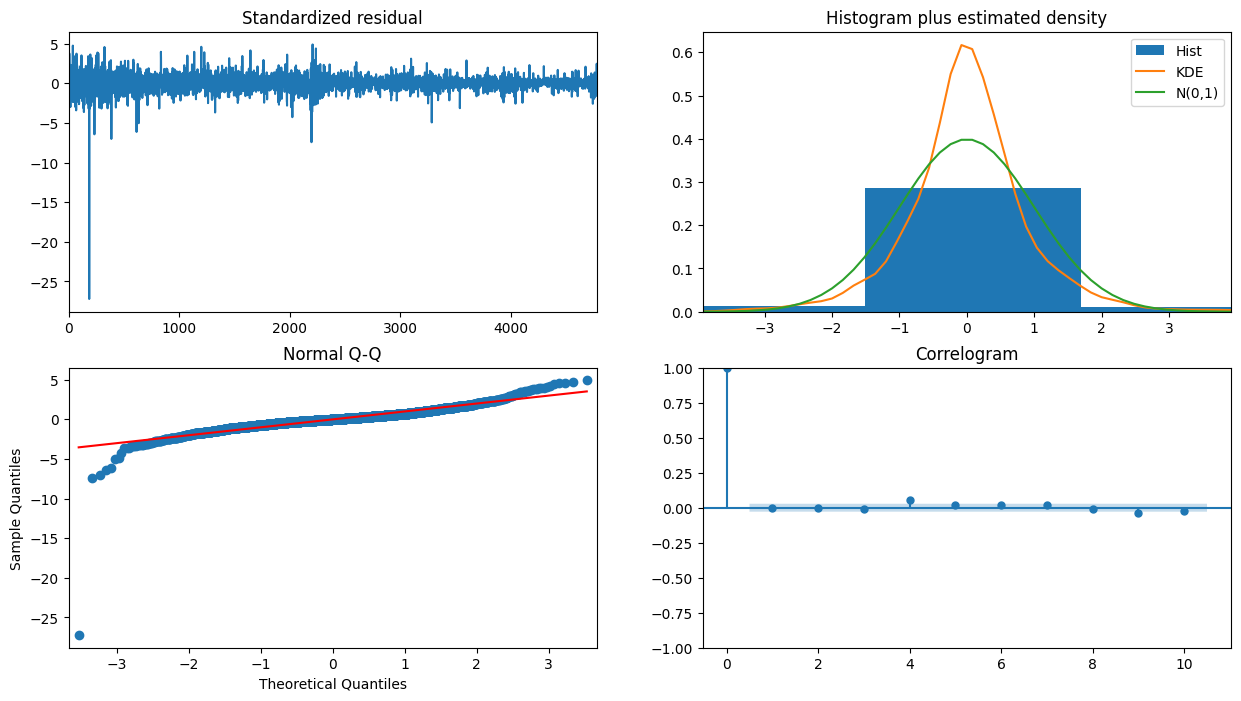

In [ ]:
AAPL_Auto_ARIMA_Model = auto_arima(Train["log return AAPL"], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(AAPL_Auto_ARIMA_Model.summary())
AAPL_Auto_ARIMA_Model.plot_diagnostics(figsize=(15,8))
plt.show()


Interprete the plot diagnostics:

**Top left:** The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

**Top Right:** The density plot on the top right suggests a normal distribution with a mean of zero.

**Bottom left:** The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

**Bottom Right:** The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

In [ ]:
AAPL_ARIMA_Model = ARIMA(Train["log return AAPL"], order = (0, 0, 1))
AAPL_ARIMA_Model_Fit = AAPL_ARIMA_Model.fit()
AAPL_predict = Test["AAPL"].mul(np.exp(AAPL_ARIMA_Model_Fit.forecast(1200, alpha=0.05)).reset_index(drop = True))

# AAPL_log_return_output = AAPL_ARIMA_Model_Fit.forecast(1200, alpha=0.05)
# AAPL_output = np.exp(AAPL_log_return_output).reset_index(drop = True)
# AAPL_predict = Test["AAPL"].mul(AAPL_output)

# Calculate rmse based on price instead log return
rmse = math.sqrt(mean_squared_error(Test["AAPL"], AAPL_predict))
print(rmse)


0.10052452620729452
